# IPSL-CM6A-ATM-ICO

conda env: new `phd_v3` (in `envs/phd`)

https://forge.ipsl.jussieu.fr/igcmg/wiki/IPSLCM6/IPSL-CM6A-ATM-ICO#IPSL-CM6A-ATM-ICO

- CM6-ICO-LR-01: `/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-LR-01.sponge.run.01/CMIP6` 
- CM6-ICO-MR-01: `/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-MR-01.sponge.run.01/CMIP6` 
- CM6-ICO-HR: `/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6`
- CM6-ICO-VHR: `/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6`

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

import warnings
warnings.filterwarnings("ignore")

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 252 GB / available: 236 GB / percent used: 6.4 %


## Define paths

In [2]:
root = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/' # CICLAD

exp_LR = 'CM6-ICO-LR-01'
exp_MR = 'CM6-ICO-MR-01'
exp_HR = 'CM6-ICO-HR'
exp_VHR = 'CM6-ICO-VHR'

# 1 year spin-up
period = slice('1982', '2013')
# period = slice('1982', '2014') ??

## Load model data

In [3]:
scf_LR = xr.open_mfdataset(root+exp_LR+'.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc').snc.sel(time=period)
scf_MR = xr.open_mfdataset(root+exp_MR+'.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc').snc.sel(time=period)
scf_HR = xr.open_mfdataset(root+exp_HR+'.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc').snc.sel(time=period)
scf_VHR = xr.open_mfdataset(root+exp_VHR+'.sponge.run.01/CMIP6/SRF/snc_LImon_*gr*.nc').snc.sel(time=period)

## Load observations

In [4]:
snc_AVHRR_1deg = xr.open_mfdataset('/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_1deg/*.nc')['scfg_interp_1deg_icefilled'].sel(time=period)
snc_AVHRR_1deg = snc_AVHRR_1deg.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2013-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
snc_AVHRR_1deg.load()
snc_AVHRR_1deg.loc['1994-10'] = snc_AVHRR_1deg.loc['1994-11'].values
snc_AVHRR_1deg['time'] = scf_LR.time

snc_AVHRR_05deg = xr.open_mfdataset('/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_0.5deg/*.nc')['scfg_interp_0.5deg_icefilled'].sel(time=period)
snc_AVHRR_05deg = snc_AVHRR_05deg.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2013-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
snc_AVHRR_05deg.load()
snc_AVHRR_05deg.loc['1994-10'] = snc_AVHRR_05deg.loc['1994-11'].values
snc_AVHRR_05deg['time'] = scf_LR.time

snc_AVHRR_025deg = xr.open_mfdataset('/data/mlalande/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_0.25deg/*.nc')['scfg_interp_0.25deg_icefilled'].sel(time=period)
snc_AVHRR_025deg = snc_AVHRR_025deg.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2013-12-31T00:00:00.000000000', freq='M')) # reindex to add dates from nov 1994 to jan 1995
snc_AVHRR_025deg.load()
snc_AVHRR_025deg.loc['1994-10'] = snc_AVHRR_025deg.loc['1994-11'].values
snc_AVHRR_025deg['time'] = scf_LR.time

## Regrid obs to model

In [5]:
regridder = xe.Regridder(snc_AVHRR_1deg, scf_LR, 'bilinear', periodic=True, reuse_weights=False)
snc_AVHRR_LR = regridder(snc_AVHRR_1deg)

regridder = xe.Regridder(snc_AVHRR_1deg, scf_MR, 'bilinear', periodic=True, reuse_weights=False)
snc_AVHRR_MR = regridder(snc_AVHRR_1deg)

regridder = xe.Regridder(snc_AVHRR_05deg, scf_HR, 'bilinear', periodic=True, reuse_weights=False)
snc_AVHRR_HR = regridder(snc_AVHRR_05deg)

regridder = xe.Regridder(snc_AVHRR_025deg, scf_VHR, 'bilinear', periodic=True, reuse_weights=False)
snc_AVHRR_VHR = regridder(snc_AVHRR_025deg)

Overwrite existing file: bilinear_180x360_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_180x360_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.
Create weight file: bilinear_360x720_360x720_peri.nc
Create weight file: bilinear_720x1440_720x1440_peri.nc


## Load topo

In [6]:
GMTED_1000deg = xr.open_dataset('/data/mlalande/GMTED2010/GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
            .drop(['nlat', 'nlon']).rename({'latitude': 'lat', 'longitude': 'lon'})
GMTED_1000deg

<xarray.Dataset>
Dimensions:           (lat: 180, lon: 360)
Coordinates:
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon               (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    elevation         (lat, lon) int16 ...
    elevation_stddev  (lat, lon) int16 ...
    elevation_max     (lat, lon) int16 ...
    elevation_min     (lat, lon) int16 ...
Attributes:
    Title:                      GMTED2010 elevation data regridded at 1.000 d...
    resolution_degrees:         1.0
    resolution_summing_factor:  240
    input_file:                 S5P_OPER_REF_DEM_15_00000000T000000_99999999T...
    input_correction:           incorrect zero elevation values in the Caspia...
    institution:                KNMI / TEMIS
    url:                        http://temis.nl/data/gmted2010/
    input_note:                 see "Original_attributes" for a copy of the a...
    history:                    2016-01-11: Conversion from HDF-5 by Maarten ...
    creation_date:              2016-02-29
    gmted2010_citation:         Danielson, J.J., and Gesch, D.B., 2011, Globa...
    gmted2010_viewer_url:       http://topotools.cr.usgs.gov/gmted_viewer/
    gmted2010_citation_url:     http://pubs.usgs.gov/of/2011/1073/pdf/of2011-...

In [7]:
GMTED_1000deg = xr.open_dataset('/data/mlalande/GMTED2010/GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
            .drop(['nlat', 'nlon']).rename({'latitude': 'lat', 'longitude': 'lon'})
regridder = xe.Regridder(GMTED_1000deg, scf_MR, 'bilinear', periodic=True, reuse_weights=False)
GMTED_MR = regridder(GMTED_1000deg)

GMTED_0500deg = xr.open_dataset('/data/mlalande/GMTED2010/GMTED2010_15n120_0500deg.nc').drop_dims('nbounds').swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
            .drop(['nlat', 'nlon']).rename({'latitude': 'lat', 'longitude': 'lon'})
regridder = xe.Regridder(GMTED_0500deg, scf_HR, 'bilinear', periodic=True, reuse_weights=False)
GMTED_HR = regridder(GMTED_0500deg)

GMTED_0250deg = xr.open_dataset('/data/mlalande/GMTED2010/GMTED2010_15n060_0250deg.nc').drop_dims('nbounds').swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
            .drop(['nlat', 'nlon']).rename({'latitude': 'lat', 'longitude': 'lon'})
regridder = xe.Regridder(GMTED_0250deg, scf_VHR, 'bilinear', periodic=True, reuse_weights=False)
GMTED_VHR = regridder(GMTED_0250deg)

Overwrite existing file: bilinear_180x360_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.
Overwrite existing file: bilinear_360x720_360x720_peri.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.
Overwrite existing file: bilinear_720x1440_720x1440_peri.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable elevation as the horizontal dimensions for this dataset.


In [8]:
list_std = [GMTED_MR.elevation_stddev.load(), GMTED_HR.elevation_stddev.load(), GMTED_VHR.elevation_stddev.load()]

In [9]:
# grid_HR = xr.open_dataset('/home/lalandmi/Dropbox/data/IGCM_OUT/ELI-512x360x79-GMTED-STD-amip_2004_grilles_gcm.nc')

# topo_HR = u.phys2dyn(xr.open_dataset('/home/lalandmi/Dropbox/data/IGCM_OUT/ELI-512x360x79-GMTED-STD-amip_2004_startphy.nc').ZMEA_NOT_FILTERED, grid_HR)
# std_HR = u.phys2dyn(xr.open_dataset('/home/lalandmi/Dropbox/data/IGCM_OUT/ELI-512x360x79-GMTED-STD-amip_2004_startphy.nc').ZSTD_NOT_FILTERED, grid_HR)

# # To have same lon from -180 to 180
# regridder = xe.Regridder(topo_HR, scf_NY07, 'bilinear', periodic=True, reuse_weights=True)
# topo_HR_regrid = regridder(topo_HR)
# std_HR_regrid = regridder(std_HR)

# topo_HR_regrid.to_netcdf('topo_HR_regrid.nc')
# std_HR_regrid.to_netcdf('std_HR_regrid.nc')

Create weight file: bilinear_361x512_361x512_peri.nc


In [6]:
# topo_HR_regrid = xr.open_dataarray('topo_HR_regrid.nc')
# std_HR_regrid = xr.open_dataarray('std_HR_regrid.nc')

## Plot

In [9]:
lat_slice_HMA, lon_slice_HMA = u.get_domain_HMA()

# Zones
# latlim_SA = slice(-60, -10); lonlim_SA = slice(-80, -60)
latlim_SA = slice(-60, -10); lonlim_SA = slice(360-80, 360-60)
latlim_US = slice(20, 70); lonlim_US = slice(360-165, 360-85)
latlim_EU = slice(30, 80); lonlim_EU = slice(0, 20)
latlim_HMA = slice(20, 55); lonlim_HMA = slice(60, 116)

In [10]:
snc_AVHRR_VHR_seas = snc_AVHRR_VHR.groupby('time.season').mean('time').load()

params = ['LR', 'MR', 'HR', 'VHR']
scf_list = []
snc_AVHRR_list = []
for da in [scf_LR, scf_MR, scf_HR, scf_VHR]:
    scf_list.append(da.groupby('time.season').mean('time').load())

for da in [snc_AVHRR_LR, snc_AVHRR_MR, snc_AVHRR_HR, snc_AVHRR_VHR]:
    snc_AVHRR_list.append(da.groupby('time.season').mean('time').load())

In [40]:
# def compute_metrics(model, obs):
#     mb = (model-obs).weighted(np.cos(np.deg2rad(model.lat))).mean().values.item(0)
#     rmse = np.sqrt(((model-obs)**2).weighted(np.cos(np.deg2rad(model.lat))).mean().values.item(0))
    
#     x = model.where(obs*0 == 0).values.flatten(); y = obs.where(model*0 == 0).values.flatten()
#     x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
#     r = stats.pearsonr(x, y)
    
#     return mb, rmse, r

In [11]:
def compute_metrics(model, obs):
    x = model.where(obs*0 == 0).values.flatten(); y = obs.where(model*0 == 0).values.flatten()
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    r = stats.pearsonr(x, y)
    
    return r

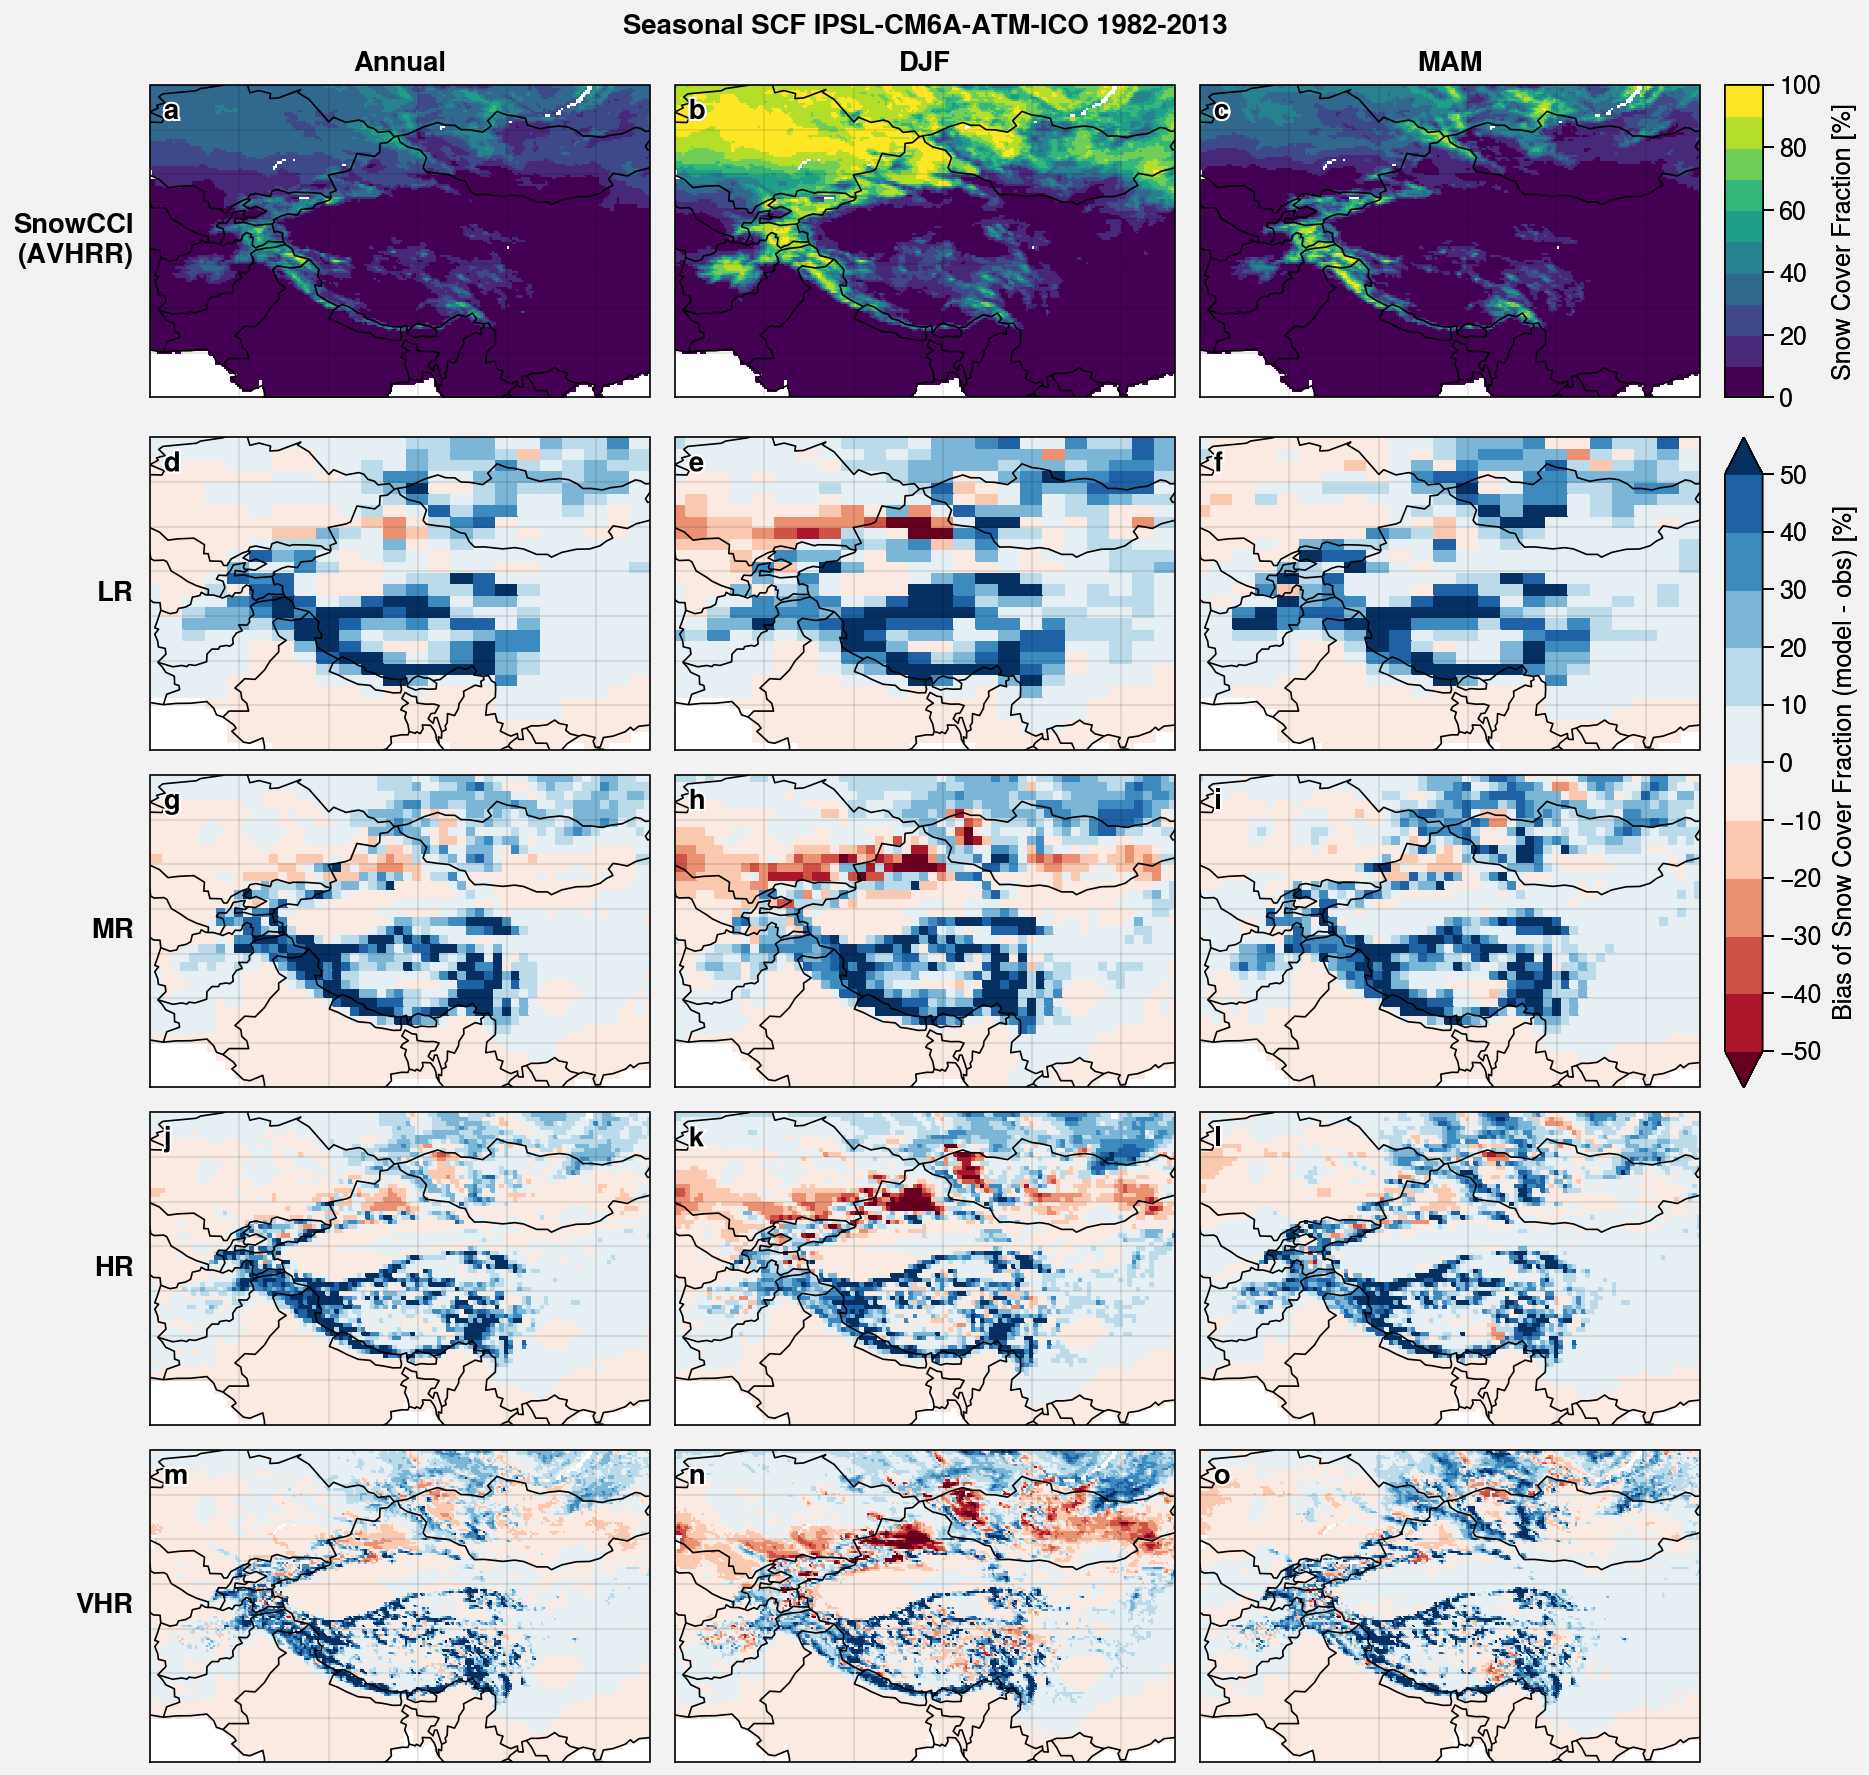

In [78]:
fig, axs = plot.subplots(ncols = 3, nrows = 5, proj='cyl', axwidth=2.5)

cmap = 'viridis'
levels = plot.arange(0, 100, 10)

cmap_bias = 'RdBu'
levels_bias = plot.arange(-50, 50, 10)
extend_bias = 'both'

threshold = 200 # STD

obs = snc_AVHRR_VHR_seas.sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
m = axs[0].pcolormesh(snc_AVHRR_VHR_seas.mean('season'), cmap=cmap, levels=levels)

obs = snc_AVHRR_VHR_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
axs[1].pcolormesh(obs, cmap=cmap, levels=levels)

obs = snc_AVHRR_VHR_seas.sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
axs[2].pcolormesh(obs, cmap=cmap, levels=levels)

k = 3
for i, param in enumerate(params):
    # Annual
    model = scf_list[i].sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
    obs = snc_AVHRR_list[i].sel(lat=latlim_HMA, lon=lonlim_HMA).mean('season')
    m_bias = axs[k].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
#     mb, rmse, (r, _) = compute_metrics(model.where(std_HR_regrid > threshold), obs.where(std_HR_regrid > threshold))
#     axs[k].format(ltitle='MB = {:.1f}%'.format(mb), ctitle='RMSE = {:.1f}%'.format(rmse), rtitle='r = {:.2}'.format(r))
    
    # DJF
    model = scf_list[i].sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
    obs = snc_AVHRR_list[i].sel(lat=latlim_HMA, lon=lonlim_HMA, season='DJF')
    axs[k+1].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
#     mb, rmse, (r, _) = compute_metrics(model.where(std_HR_regrid > threshold), obs.where(std_HR_regrid > threshold))
#     axs[k+1].format(ltitle='MB = {:.1f}%'.format(mb), ctitle='RMSE = {:.1f}%'.format(rmse), rtitle='r = {:.2}'.format(r))
    
    # MAM
    model = scf_list[i].sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
    obs = snc_AVHRR_list[i].sel(lat=latlim_HMA, lon=lonlim_HMA, season='MAM')
    axs[k+2].pcolormesh(model - obs, cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
#     mb, rmse, (r, _) = compute_metrics(model.where(std_HR_regrid > threshold), obs.where(std_HR_regrid > threshold))
#     axs[k+2].format(ltitle='MB = {:.1f}%'.format(mb), ctitle='RMSE = {:.1f}%'.format(rmse), rtitle='r = {:.2}'.format(r))
    
    k += 3
    
# for ax in axs:
#     ax.contour(std_HR_regrid, levels=[200], color='red')
#     ax.contourf(std_HR_regrid.where(std_HR_regrid > threshold), hatches=['////'], alpha=0)

fig.colorbar(m, label='Snow Cover Fraction [%]', row=1)
fig.colorbar(m_bias, label='Bias of Snow Cover Fraction (model - obs) [%]', rows=(2,3), length=1)

axs.format(
    latlim=(latlim_HMA.start, latlim_HMA.stop), lonlim=(lonlim_HMA.start, lonlim_HMA.stop),
    collabels = ['Annual', 'DJF', 'MAM'],
    rowlabels = ['SnowCCI\n(AVHRR)'] + params,
    borders=True, coast=True, labels=False, 
    abc=True, abcloc='ul',
    suptitle='Seasonal SCF IPSL-CM6A-ATM-ICO '+str(period.start)+'-'+str(period.stop) 
)

### Spatial plots

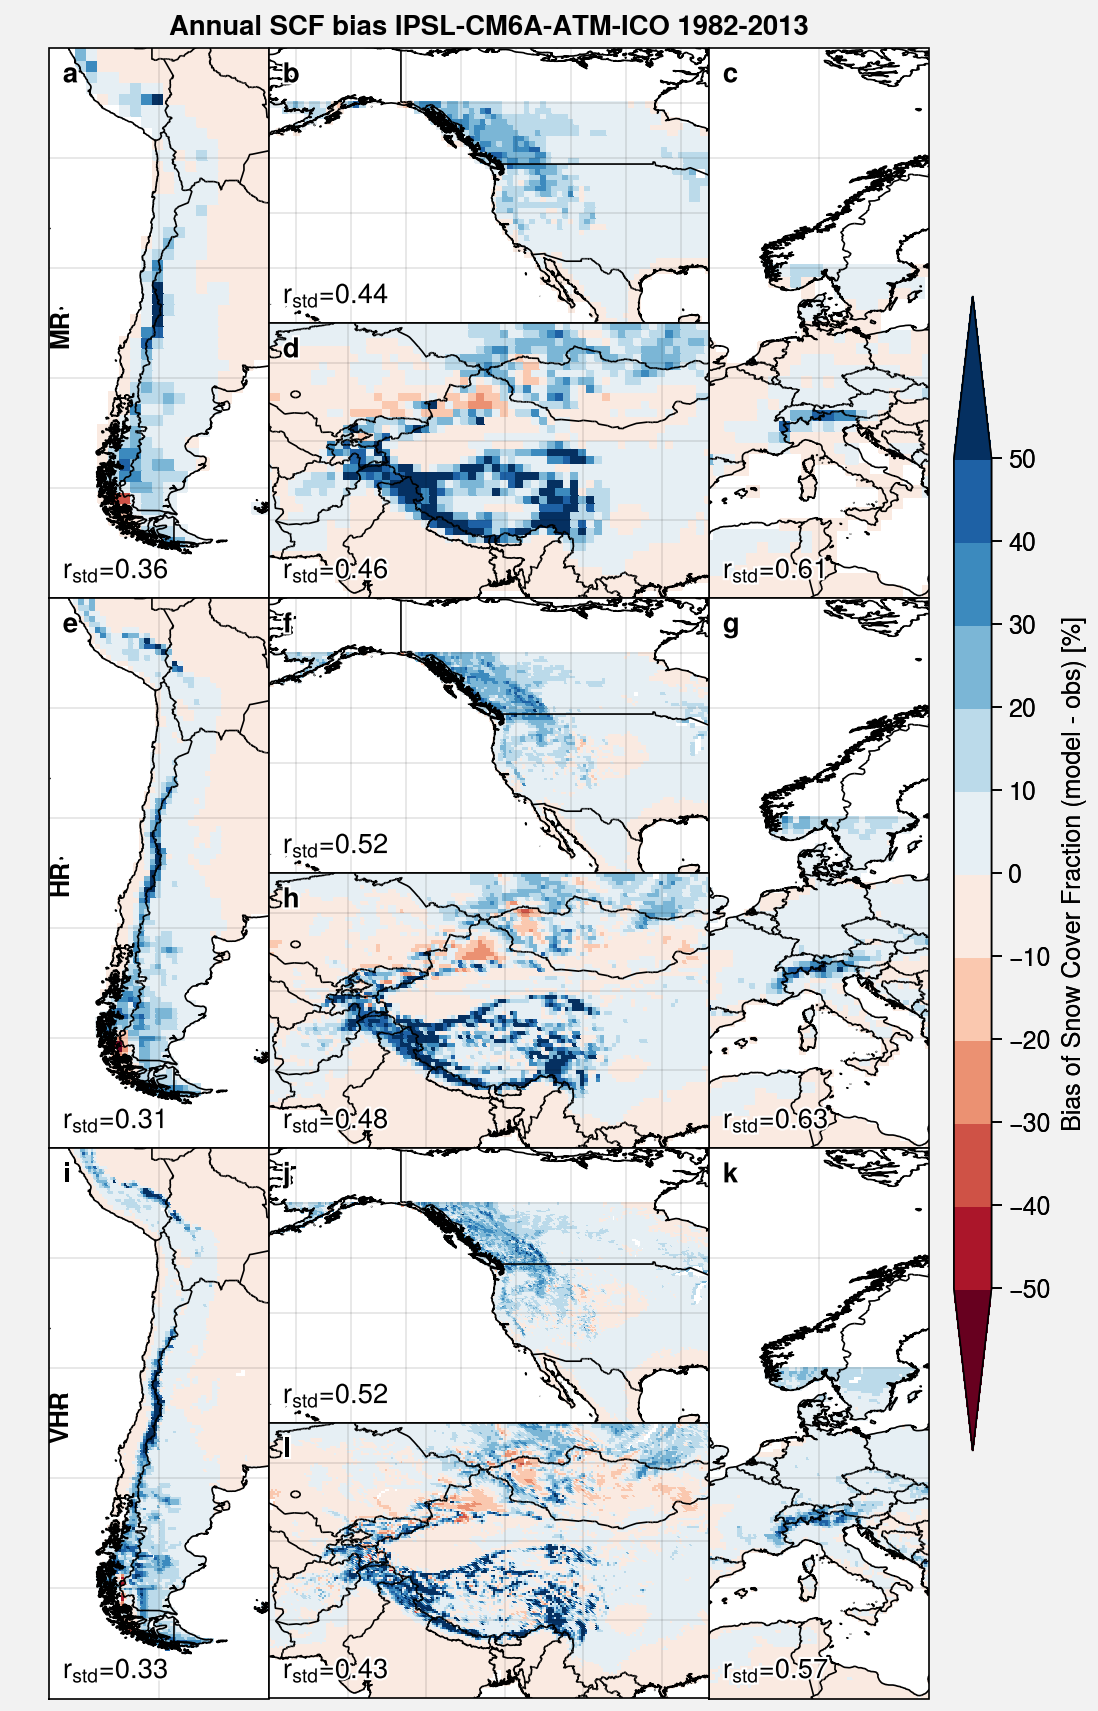

In [40]:
params = ['MR', 'HR', 'VHR']

cmap = 'RdBu'
levels = plot.arange(-50, 50, 10)
extend = 'both'

fig, axs = plot.subplots(
    [
        [1, 2, 2, 3], [1, 4, 4, 3],
        list(np.array([1, 2, 2, 3])+4), list(np.array([1, 4, 4, 3])+4),
        list(np.array([1, 2, 2, 3])+8), list(np.array([1, 4, 4, 3])+8),
    ], 
    proj='cyl', space=0, axwidth=1.1
)


for i_param, param in enumerate(params):

    obs = snc_AVHRR_list[1+i_param].mean('season')
    model = scf_list[1+i_param].mean('season')
    std = list_std[i_param] # only starting with MR

    obs = obs.where(obs.lat < 60)
    model = model.where(model.lat < 60)
    std = std.where(model.lat < 60)

    for i, (latlim, lonlim) in enumerate(zip([latlim_SA, latlim_US, latlim_EU, latlim_HMA], [lonlim_SA, lonlim_US, lonlim_EU, lonlim_HMA])):
        
        obs_subset = obs.sel(lat=latlim, lon=lonlim)
        model_subset = model.sel(lat=latlim, lon=lonlim)
        std_subset = std.sel(lat=latlim, lon=lonlim)
        m = axs[i+i_param*4].pcolormesh(model_subset - obs_subset, cmap=cmap, levels=levels, extend=extend)
        (r, _) = compute_metrics(model_subset - obs_subset, std_subset)
        axs[i+i_param*4].format(
            latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
            lltitle='r$_{std}$'+'={:.2}'.format(r)
        )


fig.colorbar(m, label='Bias of Snow Cover Fraction (model - obs) [%]', ticks=10, length=0.7)

# for ax in axs:
#     ax.contourf(std_HR_regrid.where(std_HR_regrid > threshold), hatches=['////'], alpha=0)

for pos, label in zip(np.linspace(0.16, 0.8, 3), params[::-1]):
    fig.text(0.045, pos, label, fontweight='bold', rotation='vertical')

axs.format(
    lonlines=10, latlines=10,
    suptitle='Annual SCF bias IPSL-CM6A-ATM-ICO '+str(period.start)+'-'+str(period.stop),
    coast=True, borders=True,
#     ocean=True, oceancolor='pale blue',
    abc=True, abcloc='ul', reso='hi'
)

fig.save('img/IPSL-CM6A-ATM-ICO_scf_bias_std.jpg')

## Plot topo, bias, std global

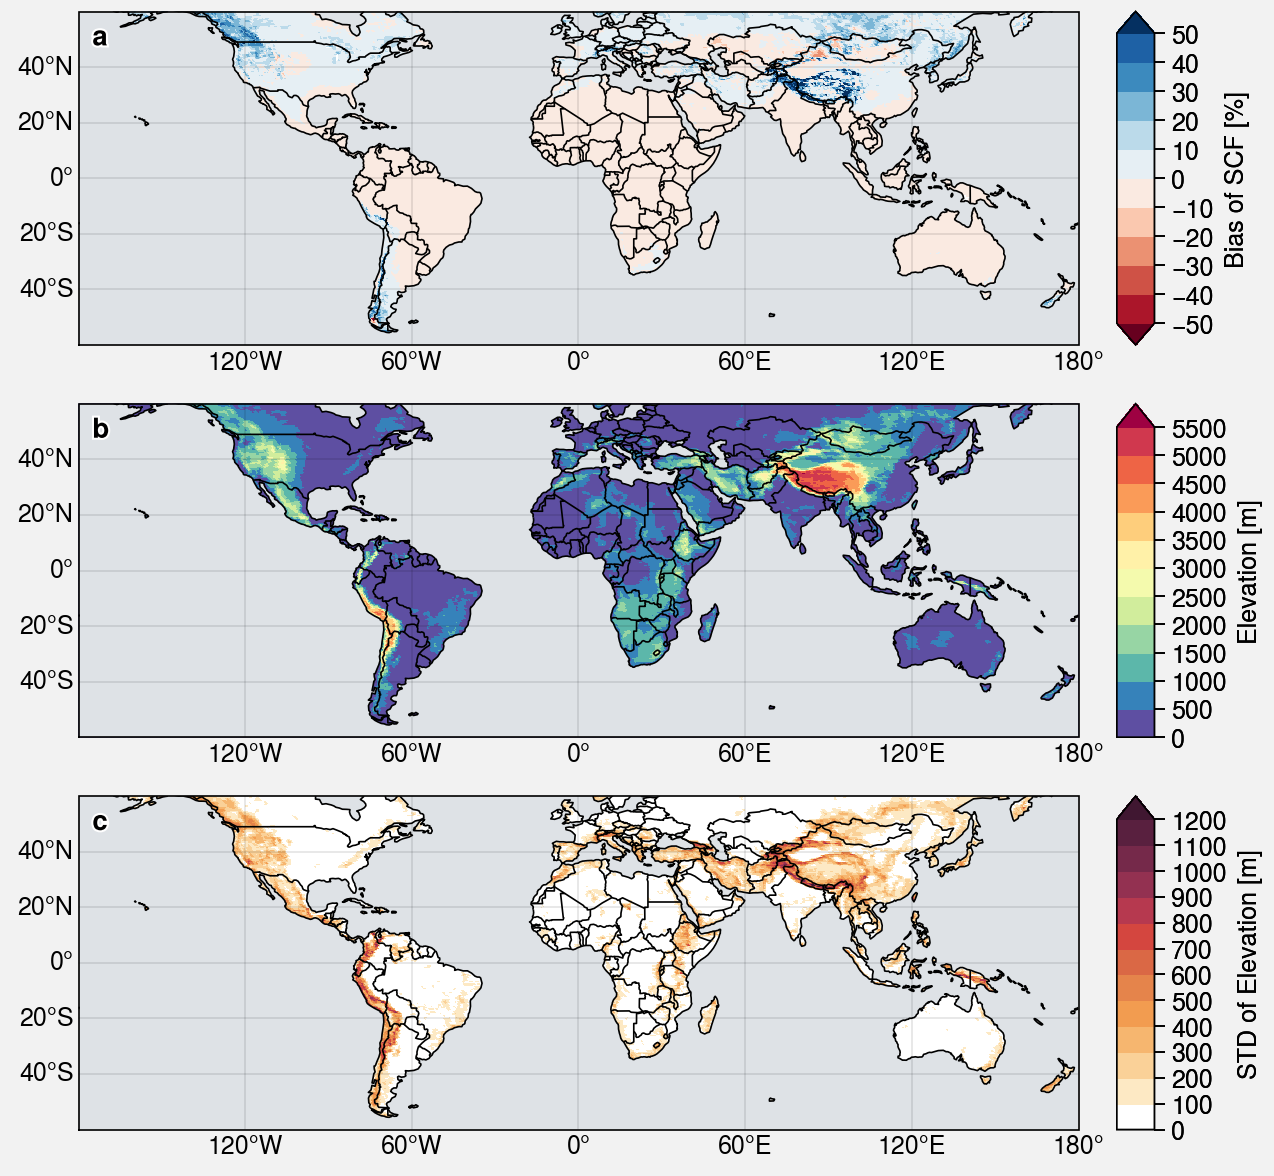

In [53]:
# Final plot

f, axs = plot.subplots(ncols=1, nrows=3, proj='cyl', axwidth=5)

extend='neither'

m0 = axs[0].pcolormesh((scf_HR.mean('time') - snc_AVHRR_HR.mean('time')), cmap='RdBu', levels=plot.arange(-50,50,10), extend='both')
axs[0].colorbar(m0, label='Bias of SCF [%]')
  
m1 = axs[1].pcolormesh(GMTED_HR.elevation, cmap='Spectral_r', levels=plot.arange(0,5500,500), extend='max')
axs[1].colorbar(m1, label='Elevation [m]')
    
m2 = axs[2].pcolormesh(GMTED_HR.elevation_stddev, levels=plot.arange(0,1200,100), extend='max')
axs[2].colorbar(m2, label='STD of Elevation [m]')


axs.format(
    labels=True, coast=True, ocean=True, oceancolor='gray3', borders=True,
#     suptitle="Annual climatology: 1981-2014 / Models: IPSL-CM6A-LR (143x142) / Observation: ",
    abc=True, latlim=(-60,60), abcloc='ul'
)

f.save('img/snc_bias_topo_std_global_HR.jpg')